In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import os
import tifffile as tf
from scipy import ndimage, stats
import utils
import math

from sklearn import cluster

def divisors(n):
    divs = [1]
    for i in range(2,int(math.sqrt(n))+1):
        if n%i == 0:
            divs.extend([i,n//i])
    divs.extend([n])
    return sorted(list(set(divs)))

In [2]:
fsrc = '../Bacteria Info for Erik/'
csrc = '../data/'
wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
sample = 'D2'
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#c44601', '#054fb9', '#5ba300', '#8babf1', '#e6308a', '#5928ed']
cmap = ['Blues_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r', 'gray', 'gist_gray', 'Wistia']


wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

ksrc += sample + os.sep

dst = fsrc

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))
transcriptomes = np.asarray(metatrans['gene'])

Cells = pd.read_excel(fsrc + 'Infected Cells w. Nuc.xlsx').values.squeeze()
cells = np.zeros_like(Cells)
for i in range(len(Cells)):
    cells[i] = metacell[metacell['orig_cellID'] == Cells[i]].index[0]

nuccutoff = 1
voronoi = tf.imread(nsrc + sample + '_EDT.tif')
nuclei = voronoi < nuccutoff

lnuc, nnuc = ndimage.label(nuclei, ndimage.generate_binary_structure(2,1))
nuc_area, _ = np.histogram(lnuc, bins=np.arange(nnuc + 2))
nuc_area[0] = 0 #ignore the non-nuclear area
print('Detected',nnuc,'nuclei')

wall[nuclei] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

cell_nucs = [ np.empty((0,2)) for _ in range(len(metacell))]

for i in range(len(cell_nucs)):
    cidx = metacell.iloc[i].name
    if metacell.loc[cidx, 'nuclei_area'] > 0:
        cidx = metacell.iloc[i].name
        cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
        s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

        uq, ct = np.unique(lnuc[s_][(lnuc[s_] > 0) & (label[s_] == cidx)], return_counts=True)
        cell_nucs[i] = np.vstack((uq,ct))

filename = csrc + sample + '_data/32771-slide1_' + sample + '_results.txt'
tlocs = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
tlocs.columns = ['X', 'Y', 'Z', 'T']

transcriptomes, invidx, tsize = np.unique(tlocs.loc[:,'T'], return_index = False, return_inverse=True, return_counts=True) 
tlocs = tlocs.loc[:, ['X','Y','Z']]
print('\nFound data for', len(transcriptomes), 'transcriptomes')

translocs = [None for i in range(len(transcriptomes))]
for tidx in range(len(transcriptomes)):
    translocs[tidx] = tlocs.loc[invidx == tidx]

zmax = tlocs['Z'].max()
zmin = tlocs['Z'].min()
Ns = divisors(zmax-zmin)[:-2]

zcells = dict()

for tidx in range(len(transcriptomes)):
    
    zcells[transcriptomes[tidx]] = dict()
    nuct = translocs[tidx].loc[ nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ]
    
    for i in range(len(metacell)):
    
        cidx = metacell.iloc[i].name
        if len(cell_nucs[i]) > 0:
            
            zcells[transcriptomes[tidx]][cidx] = dict()
            
            for j in range(len(cell_nucs[i][0])):
                nz = nuct.loc[ (label[ nuct['Y'], nuct['X'] ] == cidx) & (lnuc[ nuct['Y'], nuct['X'] ] == cell_nucs[i][0,j]), 'Z']
                zcells[transcriptomes[tidx]][cidx][cell_nucs[i][0,j]] = nz.values
                

bins = np.arange(zmin, zmax+1, Ns[2])
hparams = {'bins':bins, 'alpha':0.35, 'density':True, 'orientation':'horizontal', 'zorder':2}

Detected 1365 nuclei

Found data for 97 transcriptomes


In [5]:
tbac = pd.concat(translocs[:10], ignore_index=True)

nuct = tbac.loc[ nuclei[ tbac['Y'], tbac['X'] ] ]
cytt = tbac.loc[~nuclei[ tbac['Y'], tbac['X'] ] ]

print(nuct.shape, cytt.shape)
#metacell.loc[cells, 'number_nuclei'].sort_values(ascending=False).head(10)

(24596, 3) (1963314, 3)


In [46]:
i = 304

NX,NY,NZ = [],[],[]

cidx = metacell.iloc[i].name
cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

tx,ty,tz = translocs[tidx].loc[label[ translocs[tidx]['Y'], translocs[tidx]['X'] ] == cidx].values.T

Nx,Ny,Nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx].values.T
cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cidx].values.T
perc_nuc_inside = cell_nucs[i][1]/nuc_area[cell_nucs[i][0]]

for k in range(len(perc_nuc_inside)):
    nx,ny,nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx].loc[lnuc[ Ny, Nx ] == cell_nucs[i][0,k]].values.T
    NX.append(nx); NY.append(ny); NZ.append(nz); 

print(cidx, tz.shape, Nz.shape, nz.shape, cz.shape, len(nz) + len(cz) )

305 (0,) (83,) (83,) (1693,) 1776


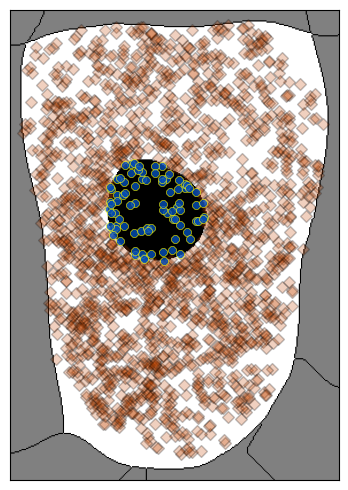

In [47]:
fig, ax = plt.subplots( 1,1, figsize=(5, 5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].imshow(cell, cmap='binary_r', origin='lower', extent=cextent, vmin=0, vmax=2, zorder=1);
ax[j].scatter(cx,cy, c=color[0], marker=marker[0], edgecolor='k', alpha=0.25, zorder=2)
for k in range(len(NZ)):
    ax[j].scatter(NX[k],NY[k], c=color[k+1], marker=marker[k+1], edgecolor='yellow', alpha=0.8, zorder=3, linewidth=0.5)
ax[j].set_facecolor('#808080')

for j in range(len(ax)):
    ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=44, statistic_sign=-1)
KstestResult(statistic=0.1842583385047889, pvalue=0.0052294858550757314, statistic_location=27, statistic_sign=1)
--


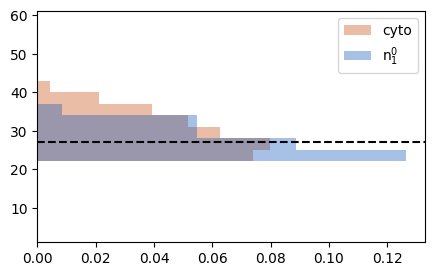

In [48]:
fig, ax = plt.subplots( 1,1, figsize=(5,3), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

h = ax[j].hist(cz, color=color[0], label='cyto', **hparams)
for k in range(len(NZ)):
    if len(NZ[k]) > 4:
        dbscan = cluster.DBSCAN(eps=2.5, min_samples=5, n_jobs=1).fit_predict(NZ[k].reshape(-1,1))
        uq = np.unique(dbscan)
        for i in uq[uq > -1]:
            nz = NZ[k][dbscan == i]
            h = ax[j].hist(nz, color=color[3*k + i+1], label='n$_{}^{}$'.format(i+1, k), **hparams)
            
            ksless = stats.ks_2samp(nz,cz,'less', method='asymp')
            ksgreater = stats.ks_2samp(nz,cz,'greater', method='asymp')
            print(ksless, ksgreater, '--', sep='\n')
            for ks in [ksless, ksgreater]:
                if ks.pvalue < 1e-2:
                    ax[j].axhline(ks.statistic_location, c='k', ls='--', zorder=3)
            
ax[j].set_ylim(zmin,zmax)
ax[j].legend(fontsize=10, loc='upper right');

#plt.savefig(dst + 'foo.jpg', bbox_inches='tight')

In [53]:
filename = dst + 'BAC_nuclear_localization_estimates.csv'

if not os.path.isfile(filename):

    columns = ['ndimage_ID', 'nuc_ID', 'perc_inside', 'N_inside', 
               'dbscan', 'nz_min', 'nz_max',
               'pval_up', 'lim_up', 'pval_down', 'lim_down']
    dfastype = {'ndimage_ID':int, 'nuc_ID':int, 'N_inside':int, 'lim_up':int, 'lim_down':int, 'nz_min':int, 'nz_max':int, 'dbscan':int}
    
    nuc_lims = []
    
    for i in range(len(metacell)):
        cidx = metacell.iloc[i].name
    
        if len(cell_nucs[i]) > 0:
        
            cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
            s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]
                
            Nx,Ny,Nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx].values.T
            cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cidx].values.T
            perc_nuc_inside = cell_nucs[i][1]/nuc_area[cell_nucs[i][0]]
            
            for k in range(len(perc_nuc_inside)):
                
                nx,ny,nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx].loc[lnuc[ Ny, Nx ] == cell_nucs[i][0,k]].values.T
                
                if len(nz) > 4:
    
                    dbscan = cluster.DBSCAN(eps=2.5, min_samples=5, n_jobs=1).fit_predict(nz.reshape(-1,1))
                    uq = np.unique(dbscan)
                    
                    for j in uq: 
    
                        z = nz[dbscan == j]
                        
                        ksless = stats.ks_2samp(z, cz,'less', method='asymp')
                        ksgreater = stats.ks_2samp(z, cz,'greater', method='asymp')
                        
                        foo = [cidx, cell_nucs[i][0,k], perc_nuc_inside[k], len(z),
                               j, z.min(), z.max(), 
                               ksless.pvalue, ksless.statistic_location, 
                               ksgreater.pvalue, ksgreater.statistic_location]
                
                        nuc_lims.append(foo)
    
    nuc_lims = np.array(nuc_lims)
    df = pd.DataFrame(nuc_lims, columns=columns).astype(dfastype)
    df.to_csv(filename, index=False)

bacs = pd.read_csv(filename)
print(bacs.shape)
bacs.head()

(700, 11)


,ndimage_ID,nuc_ID,perc_inside,N_inside,dbscan,nz_min,nz_max,pval_up,lim_up,pval_down,lim_down
0,150,83,1.0,80,0,25,41,5.585128e-21,27,0.999047,41
1,169,77,1.0,73,0,26,39,1.752500e-17,27,0.914462,39
2,216,138,1.0,4,-1,22,24,5.623976e-01,21,0.042640,24
3,216,138,1.0,94,0,28,46,2.928310e-38,35,1.000000,46
4,233,123,1.0,5,0,28,31,5.642395e-02,27,0.307894,31


# Put everything in a loop

In [109]:
columns = ['ndimage_ID', 'nuc_ID', 'perc_inside', 'N_inside', 
           'nz_min', 'nz_max',
           'pval_up', 'lim_up', 'pval_down', 'lim_down']
dfastype = {'ndimage_ID':int, 'nuc_ID':int, 'N_inside':int, 'lim_up':int, 'lim_down':int, 'nz_min':int, 'nz_max':int}

for tidx in range(10):
    
    nuc_lims = []
    filename = dst + transcriptomes[tidx] + '_nuclear_localization_estimates.csv'
    
    if not os.path.isfile(filename):
        
        nuct = translocs[tidx].loc[ nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ]
        cytt = translocs[tidx].loc[~nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ]
        
        for i in range(len(metacell)):
        
            cidx = metacell.iloc[i].name
            if len(cell_nucs[i]) > 0:
            
                cell, cextent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
                s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]
                    
                Nx,Ny,Nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx].values.T
                cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cidx].values.T
                perc_nuc_inside = cell_nucs[i][1]/nuc_area[cell_nucs[i][0]]
                
                for k in range(len(perc_nuc_inside)):
                    foo = np.zeros(10) + 1
                    nx,ny,nz = nuct.loc[label[ nuct['Y'], nuct['X'] ] == cidx].loc[lnuc[ Ny, Nx ] == cell_nucs[i][0,k]].values.T
                    foo[:4] = [cidx, cell_nucs[i][0,k], perc_nuc_inside[k], len(nz)]
                    if len(nz) > 4:
                        ksless = stats.ks_2samp(nz, cz,'less', method='asymp')
                        ksgreater = stats.ks_2samp(nz, cz,'greater', method='asymp')
                        foo[4:] = [nz.min(), nz.max(), 
                                   ksless.pvalue, ksless.statistic_location, 
                                   ksgreater.pvalue, ksgreater.statistic_location]
                    
                    nuc_lims.append(foo)

        nuc_lims = np.array(nuc_lims)
        
        df = pd.DataFrame(nuc_lims, columns=columns).astype(dfastype)
        df.to_csv(filename, index=False)
        print(tidx, transcriptomes[tidx], df.shape, sep='\t')

0	BAC45727	(1779, 10)
1	BAC46169	(1779, 10)
2	BAC47034	(1779, 10)
3	BAC47856	(1779, 10)
4	BAC48395	(1779, 10)
5	BAC51072	(1779, 10)
6	BAC51722	(1779, 10)
7	BAC52602	(1779, 10)
8	BAC52793	(1779, 10)
9	BAC52805	(1779, 10)


# Load all data and go thru the rest of genes

In [88]:
pvaltol = 1e-2
pvaldirs = ['pval_up', 'pval_down']

fbelow = (bacs['pval_up'] < pvaltol) & (bacs['pval_down'] > pvaltol) & (bacs['dbscan'] != -1) & (bacs['N_inside'] > 4)
nucbelow = bacs.loc[fbelow].sort_values(by=['ndimage_ID','nuc_ID'])
nucbelow[nucbelow.loc[:, ['ndimage_ID','nuc_ID']].duplicated(keep='first')]

,ndimage_ID,nuc_ID,perc_inside,N_inside,dbscan,nz_min,nz_max,pval_up,lim_up,pval_down,lim_down
90,475,292,1.000000,24,2,40,49,9.028874e-18,39,1.000000,49
421,1365,740,1.000000,6,1,28,30,2.337936e-04,27,0.860911,30
443,1425,779,1.000000,14,2,39,42,3.972693e-13,38,1.000000,42
638,2036,1034,0.554512,8,2,41,45,6.223295e-08,40,1.000000,45


In [93]:
cidx = 475
nidx = 292

#nucbelow[ (nucbelow['ndimage_ID'] == cidx) & (nucbelow['nuc_ID'] == nidx) ]
bacs[ (bacs['ndimage_ID'] == cidx) & (bacs['nuc_ID'] == nidx) ]

,ndimage_ID,nuc_ID,perc_inside,N_inside,dbscan,nz_min,nz_max,pval_up,lim_up,pval_down,lim_down
88,475,292,1.0,62,0,24,32,9.993014e-01,23,3.130275e-13,28
89,475,292,1.0,5,1,35,37,5.599784e-03,34,6.700725e-01,37
90,475,292,1.0,24,2,40,49,9.028874e-18,39,1.000000e+00,49


In [96]:
bacs

,ndimage_ID,nuc_ID,perc_inside,N_inside,dbscan,nz_min,nz_max,pval_up,lim_up,pval_down,lim_down
0,150,83,1.0,80,0,25,41,5.585128e-21,27,9.990465e-01,41
1,169,77,1.0,73,0,26,39,1.752500e-17,27,9.144617e-01,39
2,216,138,1.0,4,-1,22,24,5.623976e-01,21,4.264008e-02,24
3,216,138,1.0,94,0,28,46,2.928310e-38,35,1.000000e+00,46
4,233,123,1.0,5,0,28,31,5.642395e-02,27,3.078936e-01,31
...,...,...,...,...,...,...,...,...,...,...,...
695,2472,1214,1.0,7,-1,23,30,9.995777e-01,21,5.762192e-02,30
696,2472,1214,1.0,30,0,33,47,7.851261e-16,36,1.000000e+00,47
697,2514,1233,1.0,1,-1,34,34,1.213248e-01,33,9.232545e-01,34
698,2514,1233,1.0,111,0,20,32,1.000000e+00,45,1.266356e-09,28


In [76]:
tidx = 85
cidx = 2288
nidx = 1138

zcells[transcriptomes[tidx]][cidx][nidx]

array([20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26

In [77]:
foo = bacs[ (bacs['ndimage_ID'] == cidx) & (bacs['nuc_ID'] == nidx) ]
foo

,ndimage_ID,nuc_ID,perc_inside,N_inside,dbscan,nz_min,nz_max,pval_up,lim_up,pval_down,lim_down
681,2288,1138,1.0,150,0,21,46,7.242996e-33,32,1.0,46


In [164]:
cidx = 426
#cidx = 305
cidx = 1964
cdf = pd.concat([ dfs[i][dfs[i]['ndimage_ID'] == cidx] for i in range(len(dfs))], ignore_index=True, axis='index')
cdf = cdf[ (cdf['pval_up'] < 1) | (cdf['pval_down'] < 1) ]
nidx = cdf['nuc_ID'].unique()
cdf

,ndimage_ID,nuc_ID,perc_inside,N_inside,nz_min,nz_max,pval_up,lim_up,pval_down,lim_down,gene
2,1964,1008,1.0,115,22,48,0.001019,42,4.272959e-07,24,BAC47034


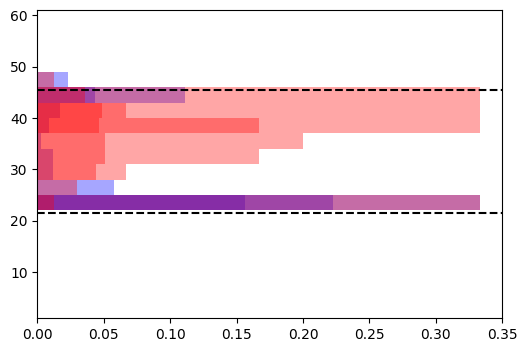

In [165]:
fig, ax = plt.subplots( 1,1, figsize=(6,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

for i in range(10):
    if len(zcells[transcriptomes[i]][cidx][nidx[0]]) > 0:
        nz = zcells[transcriptomes[i]][cidx][nidx[0]]
        ax[j].hist(nz, color='b', label=transcriptomes[i], **hparams)
for i in range(10,len(transcriptomes)):
    if len(zcells[transcriptomes[i]][cidx][nidx[0]]) > 0:
        nz = zcells[transcriptomes[i]][cidx][nidx[0]]
        ax[j].hist(nz, color='r', label=transcriptomes[i], **hparams)
        
ax[j].axhline(23-1.5, c='k', ls='--', zorder=3)
ax[j].axhline(44+1.5, c='k', ls='--', zorder=3)

ax[j].set_ylim(zmin,zmax);

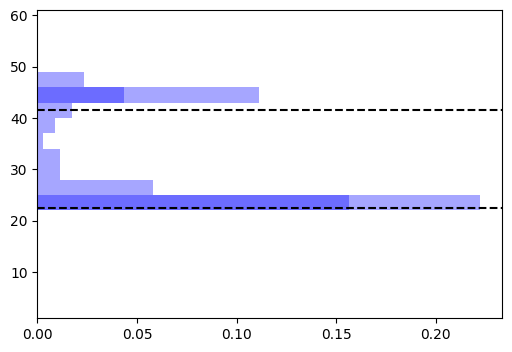

In [168]:
fig, ax = plt.subplots( 1,1, figsize=(6,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

for i in [2,7]:
    if len(zcells[transcriptomes[i]][cidx][nidx[0]]) > 0:
        nz = zcells[transcriptomes[i]][cidx][nidx[0]]
        ax[j].hist(nz, color='b', label=transcriptomes[i], **hparams)
#for i in range(10,len(transcriptomes)):
#    if len(zcells[transcriptomes[i]][cidx][nidx[0]]) > 0:
#        nz = zcells[transcriptomes[i]][cidx][nidx[0]]
#        ax[j].hist(nz, color='r', label=transcriptomes[i], **hparams)
        
ax[j].axhline(40+1.5, c='k', ls='--', zorder=3)
ax[j].axhline(21+1.5, c='k', ls='--', zorder=3)

ax[j].set_ylim(zmin,zmax);

In [130]:
pcdf = cdf.loc[ np.any(cdf.loc[:, pvaldirs] < pvaltol, axis=1)]
pcdnf= cdf.loc[~np.any(cdf.loc[:, pvaldirs] < pvaltol, axis=1)]

pcdf

,ndimage_ID,nuc_ID,perc_inside,N_inside,nz_min,nz_max,pval_up,lim_up,pval_down,lim_down,gene
2,1624,855,1.0,148,17,36,0.845521,17,0.000028,25,BAC47034
7,1624,855,1.0,9,17,23,1.000000,38,0.007154,23,BAC52602


In [ ]:

fig, ax = plt.subplots( 1,1, figsize=(5,3), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

h = ax[j].hist(cz, color=color[0], label='cyto', **hparams)
xlim = h[0].max()
for k in range(len(NZ)):
    if len(NZ[k]) > 4:
        h = ax[j].hist(NZ[k], color=color[k+1], label='nuclear', **hparams)
        #ax[j].plot(h[0],h[1][:-1],c='k',ds='steps')
        if h[0].max() > xlim:
            xlim = h[0].max()

        ksless = stats.ks_2samp(NZ[k],cz,'less', method='asymp')
        ksgreater = stats.ks_2samp(NZ[k],cz,'greater', method='asymp')
        print(ksless, ksgreater, '--', sep='\n')
        for ks in [ksless, ksgreater]:
            if ks.pvalue < 1e-2:
                ax[j].axhline(ks.statistic_location, c='k', ls='--', zorder=3)
                if ks.statistic_sign == -1:
                    ax[j].fill_between([0, xlim], ks.statistic_location, zmin, color='gray', alpha=0.25, zorder=1)
                else:
                    ax[j].fill_between([0, xlim], ks.statistic_location, zmax, color='gray', alpha=0.25, zorder=1)


ax[j].set_ylim(zmin,zmax)
ax[j].set_xlim(0, xlim)
ax[j].legend(fontsize=10, loc='upper right');

#plt.savefig(dst + 'foo.jpg', bbox_inches='tight')

In [45]:
print(np.sum(nz < 29), np.sum(nz > 29))

235 83


In [180]:
foo = df[(df['ks_greater_pval'] < tol) & (df['ks_less_pval'] > tol) & (df['N_nuclear'] > 4)]
print(foo.shape)
foo.head()

(139, 10)


,N_nuclear,N_cytosolic,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
843,95,3321,7.520509e-01,0.975317,37,3.260964e-06,23,0.999987,1.282193e-05,1
237,113,3709,3.412403e-02,0.621768,43,8.445502e-08,27,1.000000,8.193570e-08,7
811,91,2118,7.711822e-11,1.000000,44,3.689842e-07,29,1.000000,1.001650e-07,8
2065,126,4031,9.737126e-01,0.992767,20,2.065570e-08,30,1.000000,4.315144e-09,10
1776,41,1627,8.500228e-01,0.766820,37,2.547369e-11,19,1.000000,1.286629e-08,11


In [182]:
foo = df[(df['ks_greater_pval'] > tol) & (df['ks_less_pval'] < tol) & (df['N_nuclear'] > 4)]
print(foo.shape)
foo.head()

(141, 10)


,N_nuclear,N_cytosolic,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
743,78,1685,1.071965e-03,6.152819e-10,28,0.252529,39,2.435586e-06,0.999998,0
2053,110,3230,5.029636e-01,1.834098e-13,28,0.968796,38,5.156586e-12,1.000000,2
896,42,3087,3.956040e-04,3.573121e-19,27,1.000000,40,5.062833e-20,1.000000,3
2153,105,3966,3.013104e-21,1.430623e-24,31,0.999103,44,2.263118e-28,1.000000,4
752,81,3792,1.808855e-04,6.050106e-16,23,0.988683,37,1.314490e-17,1.000000,5


In [183]:
foo = df[(df['ks_greater_pval'] < tol) & (df['ks_less_pval'] < tol) & (df['N_nuclear'] > 4)]
print(foo.shape)
foo.head()

(24, 10)


,N_nuclear,N_cytosolic,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
1965,115,3085,7.828101e-01,0.001019,42,4.272959e-07,24,0.998151,0.001850,17
798,87,3023,7.377681e-01,0.000615,34,4.742673e-03,18,0.623275,0.376771,22
1620,103,2464,1.575329e-07,0.000057,34,2.034987e-06,20,0.860789,0.139242,34
932,76,2946,4.632084e-02,0.013206,33,4.208766e-05,20,0.997767,0.002234,39
1155,68,3455,9.570673e-05,0.023790,32,1.565728e-03,18,0.989533,0.010470,41


In [184]:
foo = df[ df['N_nuclear'] > 4]
print(foo.shape)
foo.head()

(321, 10)


,N_nuclear,N_cytosolic,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
743,78,1685,1.071965e-03,6.152819e-10,28,0.252529,39,2.435586e-06,0.999998,0
843,95,3321,7.520509e-01,9.753174e-01,37,0.000003,23,9.999872e-01,0.000013,1
2053,110,3230,5.029636e-01,1.834098e-13,28,0.968796,38,5.156586e-12,1.000000,2
896,42,3087,3.956040e-04,3.573121e-19,27,1.000000,40,5.062833e-20,1.000000,3
2153,105,3966,3.013104e-21,1.430623e-24,31,0.999103,44,2.263118e-28,1.000000,4


In [185]:
df.to_csv(dst + transcriptomes[tidx] + '_kolmogorov_smirnov.csv', index=True, index_label='cell..I.D.')

In [196]:
df[df['spearman_r'] == -np.abs(df.loc[df['N_nuclear'] > 4, 'spearman_r'].values).max()]

,N_nuclear,N_cytosolic,spearman_pval,spearman_r,ks_less_pval,ks_less_loc,ks_greater_pval,ks_greater_loc,mw_less_pval,mw_greater_pval,index
1787,29,576,1.028503e-16,-0.328756,1.539537e-08,28,0.95632,36,1.450407e-07,1.0,389


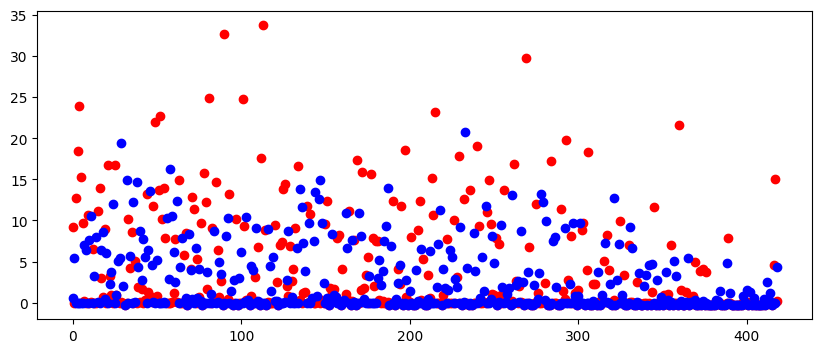

In [131]:
fig, ax = plt.subplots( 1,1, figsize=(10,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].scatter(range(len(cells)), -np.log10(df['ks_less_pval'].values), c='r')
ax[j].scatter(range(len(cells)), -np.log10(df['ks_greater_pval'].values), c='b');

In [63]:
tidx = 7
ttype = 'cytosolic'
coords = translocs[tidx].values.T

In [64]:
zcounts = [ np.zeros( (len(cells), (zmax - zmin)//Ns[i]), dtype=int) for i in range(len(Ns))]

for i in range(len(cells)):
    zcoords = translocs[tidx].loc[label[ coords[1], coords[0] ] == cells[i], 'Z'].values
    for j in range(len(Ns)):
        bins = np.arange(zmin, zmax+1, Ns[j])
        zhist, _ = np.histogram(zcoords, bins=bins)
        zcounts[j][i] = zhist

In [65]:
fs = 15
for j in range(len(Ns)):
    fig, ax = plt.subplots(1, 2,figsize=(10,5), sharex=False, sharey=True, width_ratios=[10,2])
    ax = np.atleast_1d(ax).ravel(); i=0
    ax[i].imshow(zcounts[j].T, origin='lower', cmap='inferno')
    ax[i].set_aspect(4*Ns[j])
    ax[i].set_xlabel('Infected cells w/ nucleus ('+ttype.title()+' transcripts)', fontsize=fs)
    ax[i].set_ylabel('Z-axis value', fontsize=fs)
    ax[i].set_yticks(np.arange((zmax-zmin)//Ns[j])-0.5, np.arange(zmin,zmax+1,Ns[j])[:-1])
    ax[i].set_title(transcriptomes[tidx] + ' (histogram bin width: {})'.format(Ns[j]), fontsize=fs)
    
    i+=1
    zhist = np.sum(zcounts[j], axis=0)/np.sum(zcounts[j])
    ax[i].plot(zhist, np.arange((zmax-zmin)//Ns[j]), c='b', marker='o', mfc='r')
    ax[i].set_xlabel('Proportion', fontsize=fs)
    ax[i].set_facecolor('snow')
    
    fig.tight_layout();
    filename = dst + transcriptomes[tidx] + '_' + ttype + '_histograms_{:04d}.png'.format(Ns[j])
    print(filename)
    plt.savefig(filename, format='png', dpi=200, bbox_inches='tight')
    plt.close()

../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0001.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0002.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0003.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0004.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0005.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0006.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0010.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0012.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0015.png
../Bacteria Info for Erik/BAC52602_cytosolic_histograms_0020.png


In [66]:
with pd.ExcelWriter(dst + transcriptomes[tidx] + '_' + ttype + ".xlsx") as writer:
    for j in range(len(zcounts)):
        df = pd.DataFrame(zcounts[j], index=Cells, columns = np.arange(zmin, zmax+1, Ns[j])[:-1])
        df.to_excel(writer, index=True,index_label='cell..I.D.', sheet_name='{}'.format(Ns[j]) )

In [33]:
np.sum(Cells == 504)

0

# Deal with transcripts on the edge